In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf 
from tensorflow import keras
from keras import Input
from keras import layers
import utils
import rbf_layer
from scipy.spatial import distance

# ---------------------------------------------------------------------------- #
#                                   read data                                  #
# ---------------------------------------------------------------------------- #

# data = "http://lib.stat.cmu.edu/datasets/boston"
data = "boston.csv"
raw_df = pd.read_csv(data, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]
print("Inputs:")
utils.data_summary(X)
print("Outputs:")
utils.data_summary(y)

Inputs:
Shape = (506, 13)
Minimum = 0.0
Maximum = 711.0
Range = 711.0
Variance = 21070.130450709916
Standard Deviation = 145.1555388220164

Outputs:
Shape = (506,)
Minimum = 5.0
Maximum = 50.0
Range = 45.0
Variance = 84.41955615616556
Standard Deviation = 9.188011545278203



In [4]:
# ---------------------------------------------------------------------------- #
#                                normalize data                                #
# ---------------------------------------------------------------------------- #

preprocessing.scale(X, copy=False, axis=0)
# preprocessing.scale(y, copy=False)
print("Normalized Inputs:")
utils.data_summary(X)
print(np.std(X[:,0]))

Normalized Inputs:
Shape = (506, 13)
Minimum = -3.9071933049810412
Maximum = 9.933930601860267
Range = 13.841123906841307
Variance = 1.0
Standard Deviation = 1.0

1.0


In [5]:
# ---------------------------------------------------------------------------- #
#                      split data to training and testing                      #
# ---------------------------------------------------------------------------- #

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=0)

print("Training Inputs:")
utils.data_summary(X_train)
print("Testing Inputs:")
utils.data_summary(X_test)

print("Training Outputs:")
utils.data_summary(y_train)
print("Testing Outputs:")
utils.data_summary(y_test)

n_train = X_train.shape[0]

Training Inputs:
Shape = (379, 13)
Minimum = -3.9071933049810412
Maximum = 9.933930601860267
Range = 13.841123906841307
Variance = 0.9970688559815751
Standard Deviation = 0.9985333524632891

Testing Inputs:
Shape = (127, 13)
Minimum = -3.8821945679249596
Maximum = 8.136883506576424
Range = 12.019078074501383
Variance = 1.008742396399277
Standard Deviation = 1.004361686047052

Training Outputs:
Shape = (379,)
Minimum = 5.0
Maximum = 50.0
Range = 45.0
Variance = 85.30823553163789
Standard Deviation = 9.236245748768159

Testing Outputs:
Shape = (127,)
Minimum = 5.6
Maximum = 50.0
Range = 44.4
Variance = 81.69901543803087
Standard Deviation = 9.03875076755803



In [40]:
# ---------------------------------------------------------------------------- #
#                          neural network construction                         #
# ---------------------------------------------------------------------------- #

# hidden_size = int(0.1 * n_train)
# hidden_size = int(0.5 * n_train)
hidden_size = int(0.9 * n_train)

model = keras.Sequential()
model.add(Input(shape=(13,)))
model.add(rbf_layer.RBF(hidden_size, utils.InitCentersKMeans(X_train)))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(1, activation="relu"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_2 (RBF)                 (None, 341)               4433      
                                                                 
 dense_4 (Dense)             (None, 128)               43776     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 48,338
Trainable params: 43,905
Non-trainable params: 4,433
_________________________________________________________________


In [41]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt, metrics=[utils.root_mean_squared_error, utils.coeff_determination])
history = model.fit(X_train, y_train, epochs=400, validation_data=(X_test, y_test))

Epoch 1/400
12/12 [==============================] - 1s 24ms/step - loss: 572.0259 - root_mean_squared_error: 23.8379 - coeff_determination: -6.4649 - val_loss: 529.7415 - val_root_mean_squared_error: 22.9958 - val_coeff_determination: -5.5680
Epoch 2/400
12/12 [==============================] - 0s 7ms/step - loss: 508.9398 - root_mean_squared_error: 22.4532 - coeff_determination: -5.7866 - val_loss: 456.1376 - val_root_mean_squared_error: 21.3377 - val_coeff_determination: -4.6548
Epoch 3/400
12/12 [==============================] - 0s 7ms/step - loss: 411.8665 - root_mean_squared_error: 20.2252 - coeff_determination: -4.1945 - val_loss: 336.2021 - val_root_mean_squared_error: 18.3165 - val_coeff_determination: -3.1659
Epoch 4/400
12/12 [==============================] - 0s 10ms/step - loss: 274.9439 - root_mean_squared_error: 16.4723 - coeff_determination: -2.3359 - val_loss: 200.5156 - val_root_mean_squared_error: 14.1389 - val_coeff_determination: -1.4800
Epoch 5/400
12/12 [=======

4/4 [==============================] - 0s 4ms/step - loss: 40.7517 - root_mean_squared_error: 6.3538 - coeff_determination: 0.4856


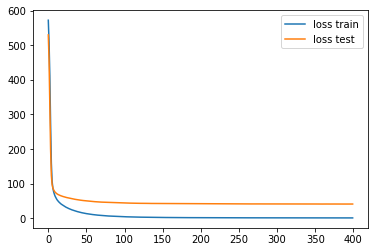

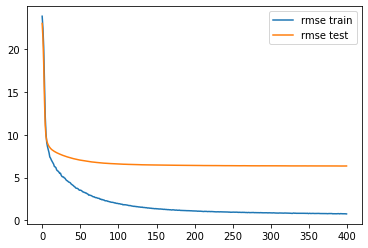

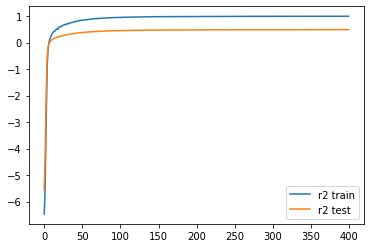

In [49]:
# ---------------------------------------------------------------------------- #
#                                    results                                   #
# ---------------------------------------------------------------------------- #

train_results = model.evaluate(X_train, y_train)
test_results = model.evaluate(X_test, y_test)
# print(train_results)
# print(test_results)

loss_train = history.history["loss"]
loss_test = history.history["val_loss"]

rmse_train = history.history["root_mean_squared_error"]
rmse_test = history.history["val_root_mean_squared_error"]

r2_train = history.history["coeff_determination"]
r2_test = history.history["val_coeff_determination"]

plt.plot(loss_train, label="loss train")
plt.plot(loss_test, label="loss test")
plt.legend()
plt.show()

plt.plot(rmse_train, label="rmse train")
plt.plot(rmse_test, label="rmse test")
plt.legend()
plt.show()

plt.plot(r2_train, label="r2 train")
plt.plot(r2_test, label="r2 test")
plt.legend()
plt.show()

